In [1]:
import sys
import os

# Add the directory that contains implementations.py
sys.path.append(os.path.abspath(r"../"))

from implementations import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from log_helpers import *
# Paths to X and y data
X_path = '..\\data\\x_train.csv'
y_path = '..\\data\\y_train.csv'

# Load the data
X, y = load_csv_data(X_path, y_path, frac=0.01)
tx, y = clean_and_standardize(X, y)

C:\Users\Max Tost\ml-project-1-overfitters-anonymous\log_helpers.py:78: RuntimeWarning: Mean of empty slice
  col_means = np.nanmean(xtest, axis=0)


In [5]:
# Set initial parameters
initial_w = np.zeros((tx.shape[1], 1))
max_iters = 300  # Number of iterations
gamma = 0.1  # Learning rate
# Cross validation
lambdas, losses_tr, losses_te = cross_validation_reg_log(y, tx, 3, np.logspace(-6, 0, 3), max_iters, gamma)

Current iteration=0, loss=0.6931471805599465
Current iteration=100, loss=0.24905466895807776
Current iteration=200, loss=0.21107399135245455
Lambda=1e-06, Training loss=0.1973673426326032
Current iteration=0, loss=0.6931471805599465
Current iteration=100, loss=0.24427866497682818
Current iteration=200, loss=0.20649082144574238
Lambda=1e-06, Training loss=0.19269703115628087
Current iteration=0, loss=0.6931471805599465
Current iteration=100, loss=0.2568675785131249
Current iteration=200, loss=0.22007143768406975
Lambda=1e-06, Training loss=0.20686199548148393
Current iteration=0, loss=0.6931471805599466
Current iteration=100, loss=0.2485054853001666
Current iteration=200, loss=0.20919648753049735
Lambda=0.001, Training loss=0.19465704224884242
Current iteration=0, loss=0.6931471805599465
Current iteration=100, loss=0.25524862683111454
Current iteration=200, loss=0.21961152874453785
Lambda=0.001, Training loss=0.20712792817085424
Current iteration=0, loss=0.6931471805599465
Current itera

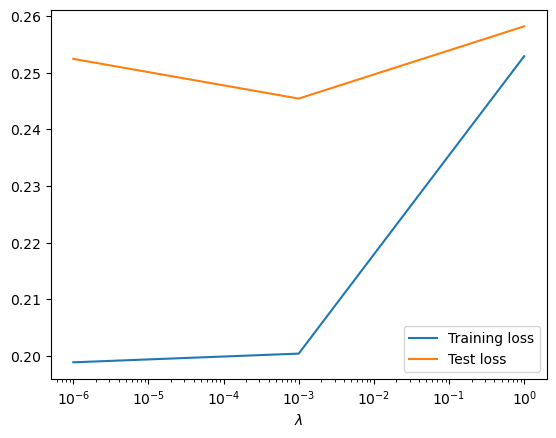

In [6]:
plt.plot(lambdas, losses_tr, label='Training loss')
plt.plot(lambdas, losses_te, label = 'Test loss')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.legend()


In [7]:
# Find the best lambda    
best_lambda = lambdas[np.argmin(rmse_te)]

In [8]:
lambda_ = best_lambda
# Set initial parameters
initial_w = np.zeros((tx.shape[1], 1))
max_iters = 10000  # Number of iterations
gamma = 0.01  # Learning rate

6.723357536499335e-06

In [ ]:
final_w, final_loss = reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma)

    print("Lambda={lam}, Training loss={l}".format(lam=lambda_, l=loss))